In [1]:
import numpy as np
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils import data
from tqdm import tqdm


class LSTMTest(nn.Module):
    def __init__(self):
        super(LSTMTest, self).__init__()

        input_dim = 1
        self.hidden_size = 64
        self.lstm = nn.LSTM(input_dim, hidden_size=self.hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)

    def forward(self, x, h0=None, c0=None, time_predictions=False):
        batched = x.ndim == 3
        # if not batched:
        #     x = x.unsqueeze(0)
        if h0 is None and c0 is None:
            lstm_out, (hn, cn) = self.lstm(x, None)  # none inits the h0,c0 to zero
        else:
            lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out)

        return out, (hn, cn)

    def n_step(self, last_prediction, hn, cn, future_steps):
        outputs = []
        last_prediction = last_prediction.unsqueeze(-1)
        with torch.no_grad():
            for i in range(future_steps):
                out, (hn, cn) = self.forward(last_prediction, hn, cn)
                outputs.append(out.squeeze(0))
                last_prediction = out
        return outputs

    def test_and_plot(self, x_test, y_test, n_steps=100):
        f = plt.figure()
        o, (h, c) = self.forward(x_test)
        preds = self.n_step(o[-1], h, c, n_steps)

        x_plt = list(np.arange(len(x_test)))
        target_plt = y_test.tolist()
        output_plt = o.squeeze(-1).tolist()

        x_plt2 = list(np.arange(n_steps) + len(x_test))
        y_plt2 = []
        for t in preds:
            y_plt2.append(t.item())

        plt.plot(x_plt, target_plt, 'k-', label='Target')
        plt.plot(x_plt, output_plt, 'b-', label='Output')
        plt.plot(x_plt2, y_plt2, 'r--', label='Future')
        plt.legend()
        return f


def create_train_data(x: torch.Tensor, y: torch.Tensor, window_size, stride=1, single_y=True):
    """
    B = number of sequences
    L = sequence length
    F = number features
    :param x: shape B,L,F if batched, else L,F
    :param y: shape B,L if batched, else L
    :param window_size:
    :param stride:
    :return: x with shape: N,window_size,F; y with shape: N,1
    """
    batched = x.ndim == 3

    x_out = x.unfold(x.ndim - 2, window_size, stride)
    x_out = x_out.swapaxes(x_out.ndim - 2, x_out.ndim - 1)

    y2 = y.unfold(x.ndim - 2, window_size, stride)

    if batched:
        y_out = y2[:, :, :, -1] if single_y else y2.swapaxes(y2.ndim - 2, y2.ndim - 1)
        y_out = y_out.flatten(0, 1)
        x_out = x_out.flatten(0, 1)
    else:
        y_out = y2[:, :, -1] if single_y else y2.swapaxes(y2.ndim - 2, y2.ndim - 1)

    return x_out, y_out

In [2]:
N = 100  # number of samples
L = 1000  # length of each sample (number of values for each sine wave)
T = 20  # width of the wave
x = np.empty((N, L), np.float32)  # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
y = np.sin(x / 1.0 / T).astype(np.float32)

x = torch.tensor(np.arange(L) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1), dtype=torch.float32).unsqueeze(-1)
y = torch.sin(x / T)

In [100]:
lstm = LSTMTest()

x_o, y_o = create_train_data(y[:, :-1], y[:, 1:], 300, 1, False)

# used for checking non-batched inputs to creat_train_data
# x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
# y_test = torch.sin(x_test / T)
# x_o, y_o = create_train_data(x_test, y_test, 300, 1, False)

dataset = data.TensorDataset(x_o, y_o)
dataset = data.TensorDataset(x[:, :-1], y[:, 1:])
train_loader = data.DataLoader(dataset, shuffle=True, batch_size=256)

epochs = 15
loss_fn = nn.MSELoss()
optimizer = optim.LBFGS(lstm.parameters(), lr=0.08)

100%|██████████| 1/1 [04:33<00:00, 273.98s/it]


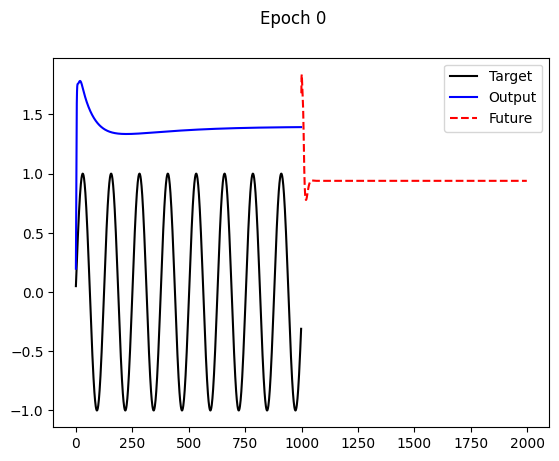

  0%|          | 0/1 [00:56<?, ?it/s]


KeyboardInterrupt: 

In [104]:
for epoch in range(epochs):
    for batch in tqdm(train_loader):
        inputs, targets = batch
        inputs.requires_grad = True

        i2 = torch.sin(inputs / T)

        def closure():
            optimizer.zero_grad()
            out, _ = lstm(i2)
            loss = loss_fn(out, targets)
            # loss.backward()

            g = torch.autograd.grad(out, inputs, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(out))[0]
            grad_target = torch.cos(inputs / T)
            loss2 = loss_fn(g, grad_target)

            final_loss = loss + loss2
            final_loss.backward(retain_graph=True)

            return final_loss

        optimizer.step(closure)

    x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
    y_test = torch.sin(x_test / T)

    fig = lstm.test_and_plot(x_test[:-1], y_test[1:], n_steps=1000)
    fig.suptitle(f"Epoch {epoch}")
    plt.show()

In [91]:
x_test = torch.tensor(np.arange(1000), dtype=torch.float32).unsqueeze(-1)
y_test = torch.sin(x_test / T)

# fig = lstm.test_and_plot(y_test[:-1], y_test[1:], n_steps=1000)
i = y_test[:-1]
i.requires_grad = True

a = x_test[:-1]
a.requires_grad = True

o, _ = lstm(torch.sin(a / T))
o.retain_grad = True

loss = loss_fn(o, y_test[1:])
# loss.backward(retain_graph=True)

# o.squeeze(-1)
# o.requires_grad_()

g = torch.autograd.grad(o, a, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(o))[0]

In [84]:
grad_target = torch.cos(a / T)
loss_fn(g, grad_target)

tensor(0.4491, grad_fn=<MseLossBackward0>)

In [92]:
g

tensor([[ 0.0396],
        [ 0.0433],
        [ 0.0454],
        [ 0.0465],
        [ 0.0470],
        [ 0.0470],
        [ 0.0467],
        [ 0.0461],
        [ 0.0453],
        [ 0.0444],
        [ 0.0434],
        [ 0.0422],
        [ 0.0408],
        [ 0.0394],
        [ 0.0379],
        [ 0.0363],
        [ 0.0345],
        [ 0.0327],
        [ 0.0308],
        [ 0.0288],
        [ 0.0268],
        [ 0.0247],
        [ 0.0225],
        [ 0.0202],
        [ 0.0179],
        [ 0.0156],
        [ 0.0132],
        [ 0.0108],
        [ 0.0084],
        [ 0.0060],
        [ 0.0035],
        [ 0.0010],
        [-0.0014],
        [-0.0039],
        [-0.0064],
        [-0.0088],
        [-0.0113],
        [-0.0137],
        [-0.0160],
        [-0.0183],
        [-0.0206],
        [-0.0229],
        [-0.0250],
        [-0.0271],
        [-0.0292],
        [-0.0312],
        [-0.0330],
        [-0.0348],
        [-0.0366],
        [-0.0382],
        [-0.0397],
        [-0.0411],
        [-0.